In [1]:
! pip3 install -q kaggle

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json /root/.kaggle

! chmod 600 /root/.kaggle/kaggle.json

! kaggle competitions download -c cassava-leaf-disease-classification

! unzip cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [1]:
import numpy as np
import pandas as pd
import os
import itertools
import os, stat, time
from os.path import dirname as up
import shutil
import glob
from PIL import Image

In [2]:
from glob import glob
data = glob('train_images/*.jpg', recursive = True)

In [3]:
len(data)

21397

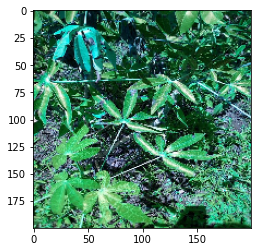

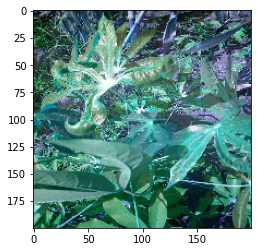

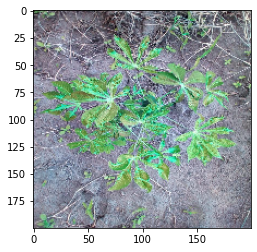

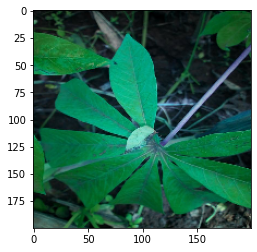

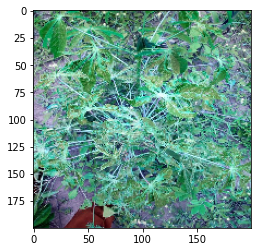

In [4]:
import cv2
import matplotlib.pyplot as plt

for i in data[:5]:
    img = cv2.imread(i)
    img_1 = cv2.resize(img, (200, 200))
    plt.imshow(img_1, cmap = 'binary')
    plt.show()

In [5]:
img_size = 70

In [6]:
import cv2
import matplotlib.pyplot as plt

images = list()
labels = list()

for i in data:
    if i.endswith('.jpg'):
        label = i[-5]
        img = cv2.imread(i)
        img_1 = cv2.resize(img, (img_size, img_size))
        images.append(img_1)
        labels.append(label)

In [7]:
len(images)

21397

In [8]:
from numpy import array

a = array(images)
a.shape

(21397, 70, 70, 3)

In [9]:
x = np.stack(images)

In [10]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(labels)

In [11]:
x = x / 255

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = 0.25)

In [13]:
print('len(x_train):', len(x_train))
print('len(x_test):', len(x_test))
print('len(y_train):', len(y_train))
print('len(y_test):', len(y_test))

len(x_train): 16047
len(x_test): 5350
len(y_train): 16047
len(y_test): 5350


In [14]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)

x_train (16047, 70, 70, 3)
x_test (5350, 70, 70, 3)
y_train (16047, 10)
y_test (5350, 10)


# Building the model

In [19]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, RepeatVector
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
from tensorflow.keras.regularizers import L2
from tensorflow.keras.applications.efficientnet import EfficientNetB7

def nn_model():
    model = models.Sequential()

    # model.add(layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu, input_shape=(img_size, img_size, 3)))
    # model.add(layers.MaxPool2D(2, 2))
    # model.add(layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu, input_shape=(img_size, img_size, 3)))
    # model.add(layers.MaxPool2D(2, 2))
    # model.add(layers.Conv2D(128, (3,3), padding='same', activation=tf.nn.relu, input_shape=(img_size, img_size, 3)))
    # model.add(layers.MaxPool2D(2, 2))

    model.add(EfficientNetB7(include_top = False, weights = 'imagenet', input_shape = (img_size, img_size, 3)))
    
    # model.add(layers.Flatten())
    
    # model.add(layers.Dropout(0.4))
    # model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = L2(0.00001)))
    # model.add(layers.Dense(128, activation = 'relu', kernel_regularizer = L2(0.00001)))

    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation = "relu"))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = nn_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 3, 3, 2560)       64097687  
                                                                 
 global_average_pooling2d_1   (None, 2560)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2560)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               655616    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                2570      
                                                      

In [20]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad =  False)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training the Model

In [21]:
history = model.fit(x, y, epochs = 25, validation_split = 0.4, batch_size = 64)

Epoch 1/25
201/201 [==============================] - 304s 1s/step - loss: 2.3555 - accuracy: 0.1026 - val_loss: 2.3172 - val_accuracy: 0.1023
Epoch 2/25
201/201 [==============================] - 247s 1s/step - loss: 2.3253 - accuracy: 0.1096 - val_loss: 2.3313 - val_accuracy: 0.1040
Epoch 3/25
201/201 [==============================] - 247s 1s/step - loss: 2.2997 - accuracy: 0.1256 - val_loss: 2.3240 - val_accuracy: 0.1033
Epoch 4/25
201/201 [==============================] - 246s 1s/step - loss: 2.2850 - accuracy: 0.1325 - val_loss: 2.3233 - val_accuracy: 0.0988
Epoch 5/25
201/201 [==============================] - 248s 1s/step - loss: 2.2718 - accuracy: 0.1429 - val_loss: 2.3245 - val_accuracy: 0.0944
Epoch 6/25
201/201 [==============================] - 247s 1s/step - loss: 2.2528 - accuracy: 0.1627 - val_loss: 2.3257 - val_accuracy: 0.0964
Epoch 7/25
201/201 [==============================] - 247s 1s/step - loss: 2.2384 - accuracy: 0.1739 - val_loss: 2.3298 - val_accuracy: 0.0977

# Evaluating the model

In [22]:
loss, accuracy = model.evaluate(x_test, y_test)

168/168 [==============================] - 31s 177ms/step - loss: 1.4524 - accuracy: 0.6120


In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train_data', 'test_data'])
plt.title('Loss Analysis')
plt.show()

In [ ]:
plt.figure(figsize = (12, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_data', 'test_data'])
plt.title('Accuracy Analysis')
plt.show()